## Analysis Methods
After downloading data from CCA, we can analyze it using Python Pandas, and Matplotlib.

In [1]:
%matplotlib inline
import glob

import pandas as pd
import matplotlib.pyplot as plt

In [9]:
data_in = 'data_in/spending_corrections_corporation_of_america.tsv.gz'
df = pd.read_csv(data_in, sep='\t', compression='gzip')

Recall, this is what the data looks like:

In [10]:
df.head(3)

,unique_transaction_id,transaction_status,dollarsobligated,baseandexercisedoptionsvalue,baseandalloptionsvalue,maj_agency_cat,mod_agency,maj_fund_agency_cat,contractingofficeagencyid,contractingofficeid,...,prime_awardee_executive4,prime_awardee_executive4_compensation,prime_awardee_executive5,prime_awardee_executive5_compensation,interagencycontractingauthority,last_modified_date,lastupdate,contract_year,filename,search_terms
0,7418eaac867ef6ac12aeafa60195ccd8,active,45000.0,0.0,0.0,"1500: JUSTICE, DEPARTMENT OF","1501: OFFICES, BOARDS AND DIVISIONS","1500: JUSTICE, DEPARTMENT OF","1501: OFFICES, BOARDS AND DIVISIONS",POS01: DEPT OF JUSTICE,...,NaN,0.0,NaN,0.0,X: Not Applicable,09/21/2000,2017-03-15,2000,datafeeds\2000_All_Contracts_Full_20170315.tsv,Corrections Corporation of America|CCA|CoreCiv...
1,01df83f4365464a1a069282bbb1fc832,active,31000.0,0.0,0.0,6400: TENNESSEE VALLEY AUTHORITY,6400: TENNESSEE VALLEY AUTHORITY,6400: TENNESSEE VALLEY AUTHORITY,6400: TENNESSEE VALLEY AUTHORITY,PURCH: TENNESSEE VALLEY AUTHORITY,...,NaN,0.0,NaN,0.0,X: Not Applicable,05/22/2000,2017-03-15,2000,datafeeds\2000_All_Contracts_Full_20170315.tsv,Corrections Corporation of America|CCA|CoreCiv...
2,96cbbd9ad0ed6d3e028fae2be8453f24,active,25000.0,25000.0,25000.0,"1500: JUSTICE, DEPARTMENT OF",1540: FEDERAL PRISON SYSTEM,:,1540: FEDERAL PRISON SYSTEM,70000: CENTRAL OFFICE,...,NaN,0.0,NaN,0.0,X: Not Applicable,06/07/2009,2017-03-15,2000,datafeeds\2000_All_Contracts_Full_20170315.tsv,Corrections Corporation of America|CCA|CoreCiv...


We have access to fast counting anf crunching in Pandas:

In [14]:
print("CoreCivic recieved ${:,.2f} since 2000".format(
    df['dollarsobligated'].sum()))

CoreCivic recieved $14,143,641,618.04 since 2000


We can perform aggragate funcions to get annual dollars obligated

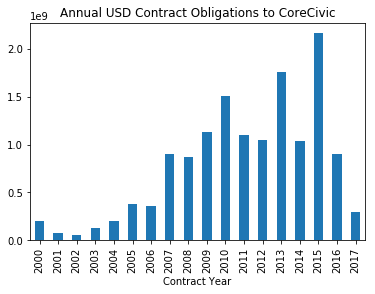

In [13]:
df.groupby('contract_year')['dollarsobligated'].sum().plot(
    kind='bar', title='Annual USD Contract Obligations to CoreCivic'
).set_xlabel('Contract Year');

Let's make these plots Seaborn-cool

In [73]:
plt.style.use('seaborn')

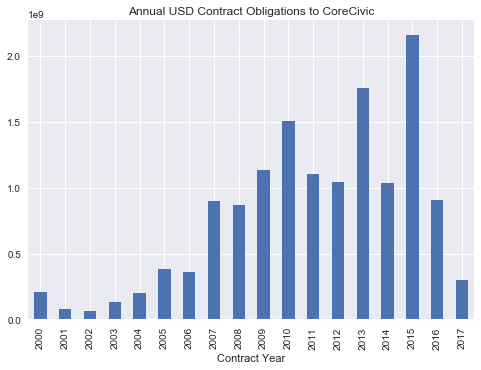

In [75]:
df.groupby('contract_year')['dollarsobligated'].sum().plot(
    kind='bar', title='Annual USD Contract Obligations to CoreCivic'
).set_xlabel('Contract Year');

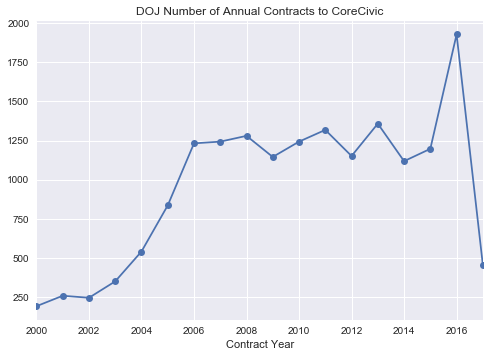

In [74]:
df[df['dollarsobligated'] > 0].groupby('contract_year')['dollarsobligated'].count().plot( 
    kind='line', marker= 'o', title='DOJ Number of Annual Contracts to CoreCivic'
).set_xlabel('Contract Year');

## What does this look like state-to-state?
We can create a chloropleth with metadata hover-ables with Plotly.

In [18]:
import us
import numpy as np
import plotly

### set up plotly
[get started](https://plot.ly/python/getting-started/) on their website to get an API key.

In [45]:
# aset up plotly creds
plotly.tools.set_credentials_file(
    username='leonyin', api_key='<get it from the site!>')

In [60]:
def group_df(df):
    df_t = df.copy()
    df_t['state_code'] = df_t['statecode'].str.split(':').str.get(0)
    
    df_merge = pd.merge(
        pd.merge(df_t.groupby('state_code')['unique_transaction_id'].count().reset_index(), 
                 df_t.groupby('state_code')['dollarsobligated'].sum().reset_index()),
        df_t.groupby('state_code')['dollarsobligated'].mean().reset_index(),
        on='state_code')
    
    df_merge.columns = ['state_code', 'contracts_count', 'total_dollars', 'mean_contract_amount']
    
    return df_merge

def build_annotation(df):
    S = [str(us.states.lookup(unicode(s))) for s in df['state_code'].tolist()]
    A = ["Avg. Contract Val: ${:,.2f}".format(int(a)) for a in df['mean_contract_amount'].tolist()]
    C = ["Num. of Contracts: {}".format(str(c)) for c in df['contracts_count'].tolist()]
    
    return ['<br>'.join([s,a,c]) for (s,a,c) in zip(S, A, C)]

def chloropleth(df):
    df3 = group_df(df)

    scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],
           [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

    data = [dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = df3['state_code'],
            z = df3['total_dollars'],
            locationmode = 'USA-states',
            text = build_annotation(df3),
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2)),
            colorbar = dict(
                title = "USD"))]

    layout = dict(
            title = ('2000-2017 DOJ Total Contract Value with CoreCivic<br>'
                     '(Hover for breakdown)'),
            geo = dict(
                scope='usa',
                projection=dict(type='albers usa'),
                showlakes=True,
                lakecolor='rgb(255, 255, 255)'))

    fig = dict( data=data, layout=layout )
    return plotly.plotly.iplot( fig, filename='d3-cloropleth-map-corecivic' )

In [61]:
chloropleth(df)

## Cross-contractor analysis
We can compare the contract data between two contractors.
Using the methods from the previous section, we can download GEO group, and compare the number of contracts and dollars obligated over time.

In [63]:
def annual_spending():
    fig, ax = plt.subplots(2, figsize=[10,6])

    df_1[df_1['dollarsobligated'] > 0].groupby(
        'contract_year')['dollarsobligated'].sum().plot( 
        kind='line', marker='o', label='CoreCivic', ax=ax[0],
        title='DOJ Annual Contracts Obligations USD'
    )

    df_2[df_2['dollarsobligated'] > 0].groupby(
        'contract_year')['dollarsobligated'].sum().plot( 
        kind='line',  marker='o', label='GEO',
        color='lightblue', ax=ax[0]
    ).get_xaxis().set_visible(False)
    
    ax[0].xaxis.set_ticks(np.arange(2000, 2017, 2))

    df_1[df_1['dollarsobligated'] > 0].groupby(
        'contract_year')['dollarsobligated'].count().plot( 
        kind='line', marker='o', ax=ax[1],
        title='DOJ Number of Annual Contracts'
    )

    df_2[df_2['dollarsobligated'] > 0].groupby(
        'contract_year')['dollarsobligated'].count().plot( 
        kind='line', marker='o', color='lightblue', ax=ax[1]
    ).set_xlabel('Contract Year')

    ax[0].legend();

In [ ]:
%ls

In [71]:
cca = 'data_in/spending_corrections_corporation_of_america.tsv.gz'
df_1 = pd.read_csv(cca, sep='\t', compression='gzip')

geo = 'data_in/spending_geo_group.tsv.gz'
df_2 = pd.read_csv(geo, sep='\t', compression='gzip')

print("CCA recieved ${:,.2f} since 2000".format(
    df_1['dollarsobligated'].sum()))
print("GEO Group recieved ${:,.2f} since 2000".format(
    df_2['dollarsobligated'].sum()))

CCA recieved $5,427,754,832.01 since 2000
GEO Group recieved $5,216,148,631.71 since 2000


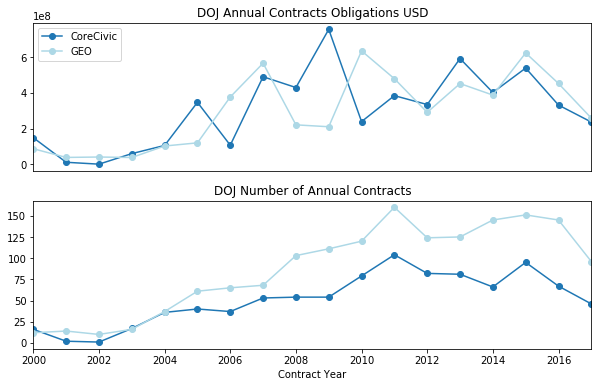

In [72]:
annual_spending()